## RE5 and RE8 Light attenuation (Sensing Secchi Disk)

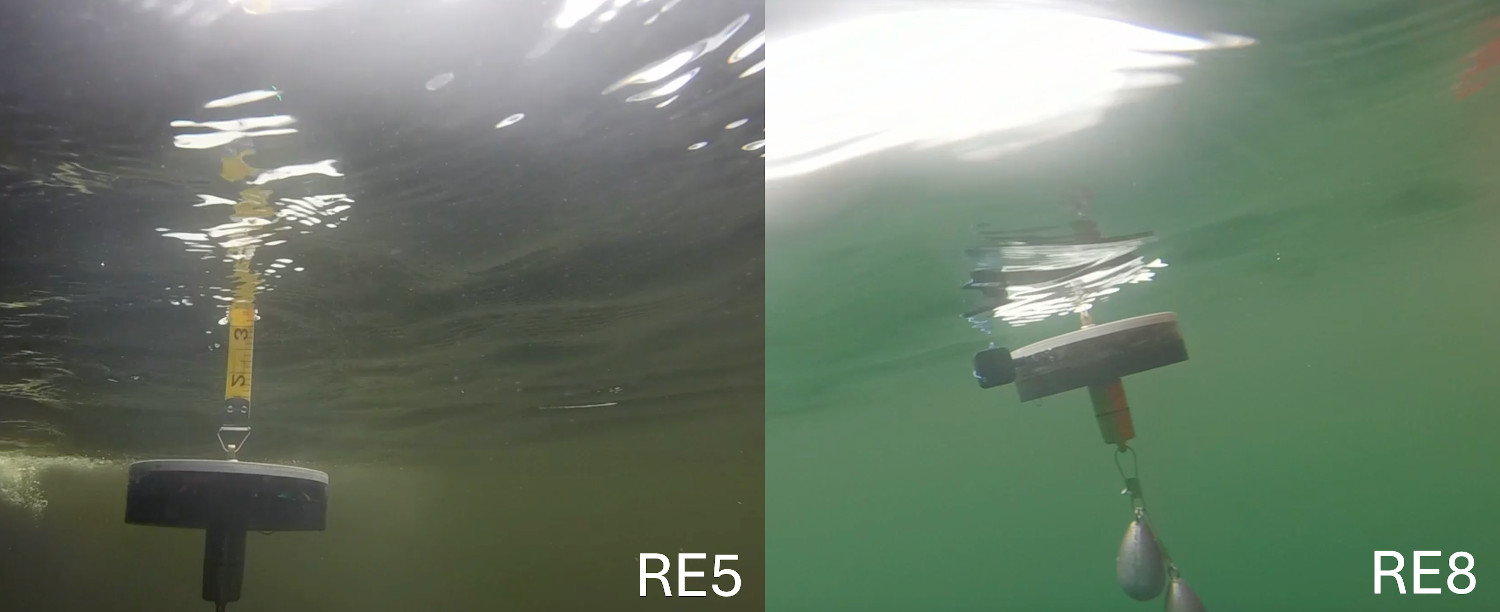

## Load programmes

In [27]:
#Programes and functions
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression
from matplotlib import ticker

###Define function for diffuse attenuation coefficient
def fcn2min_Kds(params1, X1, Y1):
        G1 = params1['G1']
        KD = params1['KD']
        model = G1+(-KD*X1)
        return(model-Y1)
    
# Supresses outputs when trying to "divide by zero" or "divide by NaN" or "treatment for floating-point overflow"
#np.seterr(divide='ignore', over='ignore', invalid='ignore');
np.seterr(all='ignore');

## RE5

In [2]:
### Set wavelengths
Wavelength = [415,445,480,515,555,590,630,680]

### HOLE 11
## SSD on CTD
File_1= '2024-05-14/240514_A005_LL_1053UTC_RE5_SSD.txt' 
#Extract Sensing Secchi data
df = pd.read_csv(File_1, header = 7)
Time_SS           = df.loc[:,'Millisecond since start'].to_numpy()
Pressure_SS       = df.loc[:,' Pressure (mbar) MS5803'].to_numpy()
Temp_MS5803_SS    = df.loc[:,' Temp (deg C) MS5803'].to_numpy()
E415nm_SS         = df.loc[:,' 415nm'].to_numpy()
E445nm_SS         = df.loc[:,' 445nm'].to_numpy()
E480nm_SS         = df.loc[:,' 480nm'].to_numpy()
E515nm_SS         = df.loc[:,' 515nm'].to_numpy()
E555nm_SS         = df.loc[:,' 555nm'].to_numpy()
E590nm_SS         = df.loc[:,' 590nm'].to_numpy()
E630nm_SS         = df.loc[:,' 630nm'].to_numpy()
E680nm_SS         = df.loc[:,' 680nm'].to_numpy()
EPARnm_SS         = df.loc[:,' Clear'].to_numpy()
ENIRnm_SS         = df.loc[:,' NIR'].to_numpy()
ATMOS_P           = np.median(Pressure_SS[0:5]) ## Assume first 5 readings (5 Sec is atmos pressure)
Depth_SS          = ((Pressure_SS - ATMOS_P)/100.) #0.02 remove for light 
Depth_SS_L        = Depth_SS - 0.00  #Correct for distance between sensor and pressure (same for A004)
DATA_SEC          = (Time_SS/1000.) + ((22*3600)+(19*60)+0) ##Time A004 was lanuched

#Process to extract downcast based on gradient of depth
asd = np.where(Depth_SS >= 0.5)
    
#Extract Profile DATA
Time_SS        = Time_SS[asd]
Pressure_SS    = Pressure_SS[asd]
Temp_MS5803_SS = Temp_MS5803_SS[asd]
E415nm_SS      = E415nm_SS[asd]
E445nm_SS      = E445nm_SS[asd]
E480nm_SS      = E480nm_SS[asd]
E515nm_SS      = E515nm_SS[asd]
E555nm_SS      = E555nm_SS[asd]
E590nm_SS      = E590nm_SS[asd]
E630nm_SS      = E630nm_SS[asd]
E680nm_SS      = E680nm_SS[asd]
EPARnm_SS      = EPARnm_SS[asd]
ENIRnm_SS      = ENIRnm_SS[asd]
Depth_SS       = Depth_SS[asd]
Depth_SS_L     = Depth_SS_L[asd]
DATA_SEC       = DATA_SEC[asd]
    
#Define array to put model parameters in
G1_spect      = np.empty([len(Wavelength)])
KD_spect      = np.empty([len(Wavelength)])
G1_spect_SE   = np.empty([len(Wavelength)])
KD_spect_SE   = np.empty([len(Wavelength)])
G1_spect_BS   = np.empty([len(Wavelength)])
KD_spect_BS   = np.empty([len(Wavelength)]) 
G1_spect_BS_SE= np.empty([len(Wavelength)])
KD_spect_BS_SE= np.empty([len(Wavelength)])
    
#Fitting Kd
for k in range(len(Wavelength)):
    if k == 0:
        Y = E415nm_SS
    if k == 1: 
        Y = E445nm_SS
    if k == 2: 
        Y = E480nm_SS
    if k == 3: 
        Y = E515nm_SS
    if k == 4: 
        Y = E555nm_SS
    if k == 5: 
        Y = E590nm_SS
    if k == 6: 
        Y = E630nm_SS
    if k == 7: 
        Y = E680nm_SS
    if k == 8:
        Y = EPARnm_SS
            
    #Fit above Secchi
    X     = Depth_SS_L
    XX    = X
    YY    = np.log(Y)
    
    asd = np.where(XX == np.max(XX))
    asd = asd[0]
    XX    = XX[asd[0]:-1]
    YY    = YY[asd[0]:-1]
    
    #Linear regression 
    model = LinearRegression().fit(XX.reshape(-1, 1), YY.reshape(-1, 1))
    y = pd.DataFrame(YY)
    x = pd.DataFrame(XX, columns=['Y']) 
    #Standard error on slope
    N = len(x)
    p = len(x.columns) + 1  # plus one because LinearRegression adds an intercept term
    X_with_intercept = np.empty(shape=(N, p), dtype=float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = x.values
    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
    y_hat = model.predict(x)
    residuals = y.values - y_hat
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
    standard_errors = np.empty(2)
    for p_ in range(p):
        standard_errors[p_] = var_beta_hat[p_, p_] ** 0.5
    G1_spect[k] =  float(model.intercept_)
    KD_spect[k] = float(model.coef_)*(-1) ###show kd non negative
    G1_spect_SE[k] = standard_errors[0] 
    KD_spect_SE[k] = standard_errors[1]     
    
E415nm_SS_RE5      = E415nm_SS
E445nm_SS_RE5      = E445nm_SS
E480nm_SS_RE5      = E480nm_SS
E515nm_SS_RE5      = E515nm_SS
E555nm_SS_RE5      = E555nm_SS
E590nm_SS_RE5      = E590nm_SS
E630nm_SS_RE5      = E630nm_SS
E680nm_SS_RE5      = E680nm_SS
EPARnm_SS_RE5      = EPARnm_SS
ENIRnm_SS_RE5      = ENIRnm_SS
Depth_SS_RE5       = Depth_SS
Depth_SS_L_RE5     = Depth_SS_L
DATA_SEC_RE5       = DATA_SEC
KD_spect_RE5       = KD_spect
G1_spect_RE5       = G1_spect

## RE8

In [3]:
### Set wavelengths
Wavelength = [415,445,480,515,555,590,630,680]

### HOLE 11
## SSD on CTD
File_1= '2024-05-14/240514_A005_LL_1308UTC_RE8_SSD.txt' 
#Extract Sensing Secchi data
df = pd.read_csv(File_1, header = 7)
Time_SS           = df.loc[:,'Millisecond since start'].to_numpy()
Pressure_SS       = df.loc[:,' Pressure (mbar) MS5803'].to_numpy()
Temp_MS5803_SS    = df.loc[:,' Temp (deg C) MS5803'].to_numpy()
E415nm_SS         = df.loc[:,' 415nm'].to_numpy()
E445nm_SS         = df.loc[:,' 445nm'].to_numpy()
E480nm_SS         = df.loc[:,' 480nm'].to_numpy()
E515nm_SS         = df.loc[:,' 515nm'].to_numpy()
E555nm_SS         = df.loc[:,' 555nm'].to_numpy()
E590nm_SS         = df.loc[:,' 590nm'].to_numpy()
E630nm_SS         = df.loc[:,' 630nm'].to_numpy()
E680nm_SS         = df.loc[:,' 680nm'].to_numpy()
EPARnm_SS         = df.loc[:,' Clear'].to_numpy()
ENIRnm_SS         = df.loc[:,' NIR'].to_numpy()
ATMOS_P           = np.median(Pressure_SS[0:5]) ## Assume first 5 readings (5 Sec is atmos pressure)
Depth_SS          = ((Pressure_SS - ATMOS_P)/100.) #0.02 remove for light 
Depth_SS_L        = Depth_SS - 0.00  #Correct for distance between sensor and pressure (same for A004)
DATA_SEC          = (Time_SS/1000.) + ((22*3600)+(19*60)+0) ##Time A004 was lanuched

#Process to extract downcast based on gradient of depth
asd = np.where(Depth_SS >= 0.5)
    
#Extract Profile DATA
Time_SS        = Time_SS[asd]
Pressure_SS    = Pressure_SS[asd]
Temp_MS5803_SS = Temp_MS5803_SS[asd]
E415nm_SS      = E415nm_SS[asd]
E445nm_SS      = E445nm_SS[asd]
E480nm_SS      = E480nm_SS[asd]
E515nm_SS      = E515nm_SS[asd]
E555nm_SS      = E555nm_SS[asd]
E590nm_SS      = E590nm_SS[asd]
E630nm_SS      = E630nm_SS[asd]
E680nm_SS      = E680nm_SS[asd]
EPARnm_SS      = EPARnm_SS[asd]
ENIRnm_SS      = ENIRnm_SS[asd]
Depth_SS       = Depth_SS[asd]
Depth_SS_L     = Depth_SS_L[asd]
DATA_SEC       = DATA_SEC[asd]
    
#Define array to put model parameters in
G1_spect      = np.empty([len(Wavelength)])
KD_spect      = np.empty([len(Wavelength)])
G1_spect_SE   = np.empty([len(Wavelength)])
KD_spect_SE   = np.empty([len(Wavelength)])
G1_spect_BS   = np.empty([len(Wavelength)])
KD_spect_BS   = np.empty([len(Wavelength)]) 
G1_spect_BS_SE= np.empty([len(Wavelength)])
KD_spect_BS_SE= np.empty([len(Wavelength)])
    
#Fitting Kd
for k in range(len(Wavelength)):
    if k == 0:
        Y = E415nm_SS
    if k == 1: 
        Y = E445nm_SS
    if k == 2: 
        Y = E480nm_SS
    if k == 3: 
        Y = E515nm_SS
    if k == 4: 
        Y = E555nm_SS
    if k == 5: 
        Y = E590nm_SS
    if k == 6: 
        Y = E630nm_SS
    if k == 7: 
        Y = E680nm_SS
    if k == 8:
        Y = EPARnm_SS
            
    #Fit above Secchi
    X     = Depth_SS_L
    XX    = X
    YY    = np.log(Y)
    
    asd = np.where(XX == np.max(XX))
    asd = asd[0]
    XX    = XX[asd[0]:-1]
    YY    = YY[asd[0]:-1]
    
    #Linear regression 
    model = LinearRegression().fit(XX.reshape(-1, 1), YY.reshape(-1, 1))
    y = pd.DataFrame(YY)
    x = pd.DataFrame(XX, columns=['Y']) 
    #Standard error on slope
    N = len(x)
    p = len(x.columns) + 1  # plus one because LinearRegression adds an intercept term
    X_with_intercept = np.empty(shape=(N, p), dtype=float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = x.values
    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
    y_hat = model.predict(x)
    residuals = y.values - y_hat
    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
    standard_errors = np.empty(2)
    for p_ in range(p):
        standard_errors[p_] = var_beta_hat[p_, p_] ** 0.5
    G1_spect[k] =  float(model.intercept_)
    KD_spect[k] = float(model.coef_)*(-1) ###show kd non negative
    G1_spect_SE[k] = standard_errors[0] 
    KD_spect_SE[k] = standard_errors[1]     
    
E415nm_SS_RE8      = E415nm_SS
E445nm_SS_RE8      = E445nm_SS
E480nm_SS_RE8      = E480nm_SS
E515nm_SS_RE8      = E515nm_SS
E555nm_SS_RE8      = E555nm_SS
E590nm_SS_RE8      = E590nm_SS
E630nm_SS_RE8      = E630nm_SS
E680nm_SS_RE8      = E680nm_SS
EPARnm_SS_RE8      = EPARnm_SS
ENIRnm_SS_RE8      = ENIRnm_SS
Depth_SS_RE8       = Depth_SS
Depth_SS_L_RE8     = Depth_SS_L
DATA_SEC_RE8       = DATA_SEC
KD_spect_RE8       = KD_spect
G1_spect_RE8       = G1_spect

### Plot

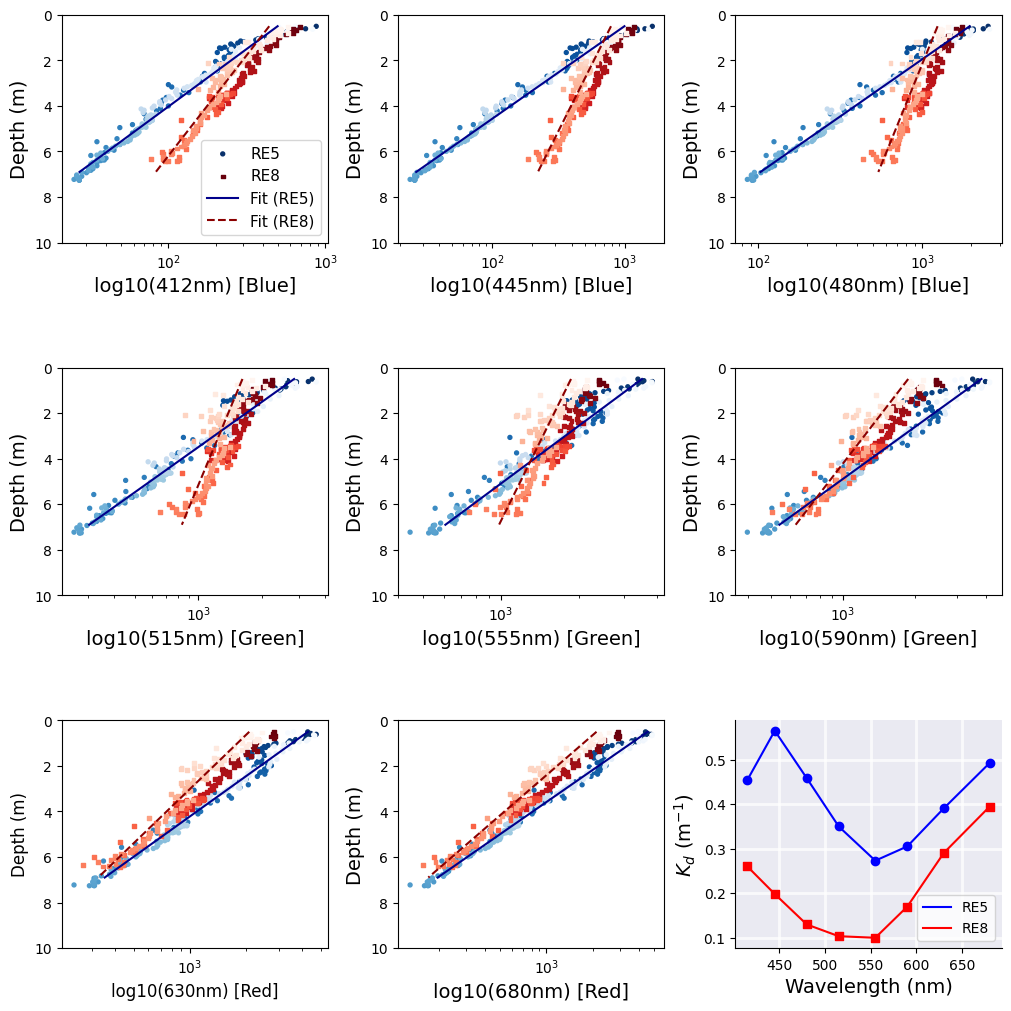

In [4]:
#### Depth array
Depth_sim = np.arange(0.5, 7, 0.1)

#Plotting 
fig, ([ax3, ax4, ax5],[ax6, ax7, ax8],[ax9, ax10, ax11]) = plt.subplots(3,3,  figsize=(10,10), \
    constrained_layout=True, gridspec_kw={'hspace': 0.2})
im3 = ax3.scatter(E415nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r', label = 'RE5')
im4 = ax3.scatter(E415nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r', label = 'RE8')
ax3.plot((np.exp(G1_spect_RE5[0])*np.exp(-KD_spect_RE5[0]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax3.plot((np.exp(G1_spect_RE8[0])*np.exp(-KD_spect_RE8[0]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax3.set_ylabel('Depth (m)', fontsize=14)
ax3.set_xlabel('log10(412nm) [Blue]', fontsize=14)
ax3.set_ylim([10,0])
ax3.set_xscale('log')
ax3.legend(loc="lower right", fontsize=11)

im5 = ax4.scatter(E445nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im6 = ax4.scatter(E445nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax4.plot((np.exp(G1_spect_RE5[1])*np.exp(-KD_spect_RE5[1]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax4.plot((np.exp(G1_spect_RE8[1])*np.exp(-KD_spect_RE8[1]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax4.set_ylabel('Depth (m)', fontsize=14)
ax4.set_xlabel('log10(445nm) [Blue]', fontsize=14)
ax4.set_ylim([10,0])
ax4.set_xscale('log')

im7 = ax5.scatter(E480nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im8 = ax5.scatter(E480nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax5.plot((np.exp(G1_spect_RE5[2])*np.exp(-KD_spect_RE5[2]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax5.plot((np.exp(G1_spect_RE8[2])*np.exp(-KD_spect_RE8[2]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax5.set_ylabel('Depth (m)', fontsize=14)
ax5.set_xlabel('log10(480nm) [Blue]', fontsize=14)
ax5.set_ylim([10,0])
ax5.set_xscale('log')

im9 = ax6.scatter(E515nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im10 = ax6.scatter(E515nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax6.plot((np.exp(G1_spect_RE5[3])*np.exp(-KD_spect_RE5[3]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax6.plot((np.exp(G1_spect_RE8[3])*np.exp(-KD_spect_RE8[3]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax6.set_ylabel('Depth (m)', fontsize=14)
ax6.set_xlabel('log10(515nm) [Green]', fontsize=14)
ax6.set_ylim([10,0])
ax6.set_xscale('log')

im11 = ax7.scatter(E555nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im12 = ax7.scatter(E555nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax7.plot((np.exp(G1_spect_RE5[4])*np.exp(-KD_spect_RE5[4]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax7.plot((np.exp(G1_spect_RE8[4])*np.exp(-KD_spect_RE8[4]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax7.set_ylabel('Depth (m)', fontsize=14)
ax7.set_xlabel('log10(555nm) [Green]', fontsize=14)
ax7.set_ylim([10,0])
ax7.set_xscale('log')

im13 = ax8.scatter(E590nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im14 = ax8.scatter(E590nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax8.plot((np.exp(G1_spect_RE5[5])*np.exp(-KD_spect_RE5[5]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax8.plot((np.exp(G1_spect_RE8[5])*np.exp(-KD_spect_RE8[5]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax8.set_ylabel('Depth (m)', fontsize=14)
ax8.set_xlabel('log10(590nm) [Green]', fontsize=14)
ax8.set_ylim([10,0])
ax8.set_xscale('log')

im15 = ax9.scatter(E630nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im16 = ax9.scatter(E630nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax9.plot((np.exp(G1_spect_RE5[6])*np.exp(-KD_spect_RE5[6]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax9.plot((np.exp(G1_spect_RE8[6])*np.exp(-KD_spect_RE8[6]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax9.set_ylabel('Depth (m)', fontsize=12)
ax9.set_xlabel('log10(630nm) [Red]', fontsize=12)
ax9.set_ylim([10,0])
ax9.set_xscale('log')


im17 = ax10.scatter(E680nm_SS_RE5,Depth_SS_L_RE5, c = DATA_SEC_RE5, marker='o', s = 8, cmap = 'Blues_r')
im18 = ax10.scatter(E680nm_SS_RE8,Depth_SS_L_RE8, c = DATA_SEC_RE8, marker='s', s = 8, cmap = 'Reds_r')
ax10.plot((np.exp(G1_spect_RE5[7])*np.exp(-KD_spect_RE5[7]*Depth_sim)),Depth_sim, linestyle = '-', color = 'darkblue', label = 'Fit (RE5)')
ax10.plot((np.exp(G1_spect_RE8[7])*np.exp(-KD_spect_RE8[7]*Depth_sim)),Depth_sim, linestyle = '--', color = 'darkred', label = 'Fit (RE8)')
ax10.set_ylabel('Depth (m)', fontsize=14)
ax10.set_xlabel('log10(680nm) [Red]', fontsize=14)
ax10.set_ylim([10,0])
ax10.set_xscale('log')

#plot 1   
ax11.plot(Wavelength,KD_spect_RE5,color = 'b', label = 'RE5')
ax11.scatter(Wavelength,KD_spect_RE5,color = 'b', marker = 'o')
ax11.plot(Wavelength,KD_spect_RE8,color = 'r', label = 'RE8')
ax11.scatter(Wavelength,KD_spect_RE8,color = 'r', marker = 's')
ax11.set_xlabel('Wavelength (nm)', fontsize=14)  
ax11.set_ylabel('$K_d$ (m$^{-1}$)', fontsize=14) 
ax11.legend(loc="lower right", fontsize=10)
ax11.set_facecolor('#eaeaf2')
ax11.grid(color = 'white', alpha=0.75, linewidth = 2)
ax11.set_axisbelow(True)
ax11.spines['right'].set_visible(False)
ax11.spines['top'].set_visible(False)

plt.show()

## Secchi depth and Forel Ule Colour

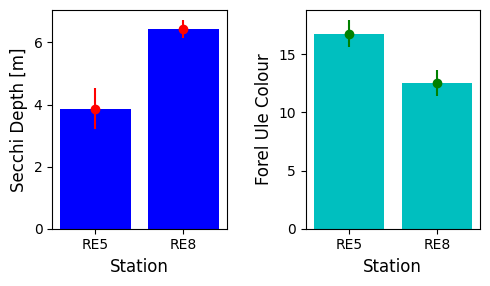

In [33]:
#Data from Lydia's notebook
RE5_Secchi = [5.2,3.7,3.9,3.9,3.16,3.3]
RE5_FU     = [18,17,17,18,16,17,18,15,15]
RE8_Secchi = [6.1,6.6,6.8,6.2]
RE8_FU     = [12,14,13,11]

#Average and standard deviation
RE5_Secchi_Mean  = np.mean(RE5_Secchi)
RE5_Secchi_STDEV = np.std(RE5_Secchi)
RE8_Secchi_Mean  = np.mean(RE8_Secchi)
RE8_Secchi_STDEV = np.std(RE8_Secchi)
RE5_FU_Mean  = np.mean(RE5_FU)
RE5_FU_STDEV = np.std(RE5_FU)
RE8_FU_Mean  = np.mean(RE8_FU)
RE8_FU_STDEV = np.std(RE8_FU)

#Aggregrate data
Labels     = ['RE5','RE8']
Secchi     = [RE5_Secchi_Mean,RE8_Secchi_Mean]
Secchi_SDV = [RE5_Secchi_STDEV,RE8_Secchi_STDEV]
FU         = [RE5_FU_Mean,RE8_FU_Mean]
FU_SDV     = [RE5_FU_STDEV,RE8_FU_STDEV]

#Plot 
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(5,3))
ax1.bar(Labels, Secchi, color = 'b')
ax1.errorbar(Labels, Secchi, yerr=Secchi_SDV, fmt="o", color="r")
ax1.set_ylabel('Secchi Depth [m]', fontsize=12, color='k')
ax1.set_xlabel('Station', fontsize=12, color='k')
 
ax2.bar(Labels, FU, color = 'c')
ax2.errorbar(Labels, FU, yerr=FU_SDV, fmt="o", color="g")
ax2.set_ylabel('Forel Ule Colour', fontsize=12, color='k')
ax2.set_xlabel('Station', fontsize=12, color='k')

plt.tight_layout()
plt.show()